# Listen, Attend and Spell (LAS)

# https://arxiv.org/pdf/1508.01211

## Abstract
The paper introduces **Listen, Attend and Spell (LAS)**, an attention-based end-to-end speech recognition model. Unlike traditional hybrid systems (DNN-HMM) or CTC-based approaches, LAS jointly learns **acoustic and language modeling** without assuming independence between output units. It directly maps speech to **characters**, enabling robust transcription and handling out-of-vocabulary words.

---

## Problems
- **Disjoint training in prior ASR systems**: Acoustic, pronunciation, and language models were trained separately with different objectives.  
- **CTC limitations**: CTC enforces conditional independence across labels, limiting flexibility in transcription.  
- **Seq2Seq prior attempts**: Previous sequence-to-sequence models only predicted phonemes, not characters.  
- **Training complexity**: Long acoustic sequences made RNN training inefficient.  
- **Mismatch between training and inference**: Teacher-forcing ignores errors during autoregressive decoding, creating exposure bias.  

---

## Proposed Solutions
- **LAS model design**:  
  - **Listener**: A pyramidal BLSTM encoder reduces sequence length, generating high-level speech features.  
  - **Speller**: An attention-based decoder generates character sequences autoregressively.  
- **Attention mechanism**: Content-based attention dynamically aligns audio frames with character predictions.  
- **Scheduled sampling variant**: Reduces exposure bias by occasionally sampling from the model’s predictions during training.  
- **Beam search with LM rescoring**: External language model improves decoding accuracy.  

---

## Purpose
To develop a **fully end-to-end neural speech recognizer** that:  
1. Eliminates handcrafted components (HMMs, pronunciation dictionaries).  
2. Addresses CTC’s independence limitation.  
3. Achieves competitive large-scale ASR performance with interpretable alignments.  

---

## Methodology
- **Architecture**: Pyramid BLSTM encoder + Attention-based LSTM decoder.  
- **Objective**: Maximize conditional likelihood of character sequences with cross-entropy, incorporating scheduled sampling.  
- **Decoding**: Beam search with optional LM rescoring.  
- **Dataset**: ~2000 hours (≈3M utterances) of Google Voice Search with noise and reverberation augmentation.  
- **Evaluation**: Word Error Rate (WER).  

---

## Results
- **Baseline LAS (no LM)**: 16.2% WER (clean), 19.0% (noisy).  
- **LAS + LM rescoring**: 12.6% WER (clean), 14.7% (noisy).  
- **LAS + Sampling**: 14.1% WER (clean), 16.5% (noisy).  
- **LAS + Sampling + LM rescoring**: 10.3% WER (clean), 12.0% (noisy).  
- **CLDNN-HMM baseline**: 8.0% (clean), 8.9% (noisy).  

**Attention visualizations** show monotonic alignments between frames and characters, demonstrating interpretability.  

---

## Conclusions
- **LAS proves feasibility** of end-to-end, character-based ASR without HMMs, phonemes, or pronunciation dictionaries.  
- It addresses **CTC’s independence limitation** and implicitly learns language modeling.  
- While it underperforms slightly compared to CLDNN-HMM, its **simplicity, generalizability, and interpretability** make LAS a **foundational step** toward modern attention-based ASR systems.  


# Mathematical and Statistical Content in *Listen, Attend and Spell (LAS)*

## 1. Conditional Probability of Output Sequence
The LAS model predicts a sequence of characters  
\( y = (y_1, y_2, \ldots, y_S) \) given acoustic frames  
\( x = (x_1, x_2, \ldots, x_T) \):

$$
P(y \mid x) = \prod_{i=1}^{S} P(y_i \mid y_{<i}, x)
$$

- Each character \( y_i \) depends on all previous outputs \( y_{<i} \) and the full input sequence \( x \).  
- Unlike **CTC**, LAS does not assume independence between output labels.  

---

## 2. Encoder Function (Listener)
The encoder converts the acoustic input into high-level features:

$$
h = \text{Listener}(x)
$$

- Implemented as a **pyramidal BLSTM** that concatenates adjacent frames, reducing temporal resolution.  
- Produces a compressed sequence \( h \) of hidden states that capture long-range dependencies.  

---

## 3. Attention Mechanism
At decoding step \( i \), the context vector is a weighted sum of encoder states:

$$
c_i = \sum_{u=1}^{U} \alpha_{i,u} h_u
$$

where:  
- \( h_u \): encoder hidden state at time \( u \).  
- \( \alpha_{i,u} \): attention weight, computed as:

$$
\alpha_{i,u} = \frac{\exp(e_{i,u})}{\sum_{u'} \exp(e_{i,u'})}
$$

with energy score:

$$
e_{i,u} = \text{Score}(s_{i-1}, h_u)
$$

- \( s_{i-1} \): previous decoder state.  
- Role: **Dynamic alignment** between speech frames and output characters.  

---

## 4. Decoder Function (Speller)
The decoder (LSTM) predicts the next character distribution:

$$
s_i = \text{LSTM}(s_{i-1}, y_{i-1}, c_i)
$$

$$
P(y_i \mid y_{<i}, x) = \text{Softmax}(W[s_i, c_i] + b)
$$

- \( s_i \): decoder hidden state.  
- Combines past hidden state, previous character embedding, and current context vector.  

---

## 5. Training Objective
The model is trained by minimizing cross-entropy:

$$
L = - \sum_{i=1}^{S} \log P(y_i \mid y_{<i}, x)
$$

- **Teacher forcing**: ground-truth token \( y_{i-1} \) is fed at training time.  
- **Scheduled sampling**: occasionally uses predicted tokens instead of ground truth to reduce exposure bias.  

---

## 6. Beam Search with Language Model
During inference, LAS uses beam search:

$$
y^* = \arg \max_y \; \big[ \log P(y \mid x) + \lambda \log P_{LM}(y) \big]
$$

- \( P(y \mid x) \): LAS model score.  
- \( P_{LM}(y) \): external LM score.  
- \( \lambda \): weighting factor.  
- Role: integrates stronger linguistic prior for improved decoding.  

---

## 7. Evaluation Metric: Word Error Rate (WER)
Performance is measured with WER:

$$
WER = \frac{S + D + I}{N}
$$

- \( S \): substitutions  
- \( D \): deletions  
- \( I \): insertions  
- \( N \): total words in reference  

---

##  Summary
The **mathematical framework of LAS** is built on:

1. **Autoregressive probability modeling** of character sequences.  
2. **Attention mechanism** for dynamic frame-to-character alignment.  
3. **Cross-entropy loss** with scheduled sampling to mitigate exposure bias.  
4. **Beam search + LM rescoring** for robust inference.  
5. **WER** as the evaluation standard.  

Together, these components formalize LAS as a fully end-to-end sequence-to-sequence ASR system, overcoming **CTC’s independence assumptions** and the modular complexity of hybrid **DNN-HMM** pipelines.


```
+-----------------------------------------------------------------------------------+
|                        Listen, Attend and Spell (LAS) Model                       |
+-----------------------------------------------------------------------------------+

 Input Acoustic Features (x_1 ... x_T)
  (e.g., log-Mel filterbanks)
                |
                v
 +-----------------------------+
 |   Listener (Encoder)        |
 |  Pyramidal BLSTM            |
 |  - Stacks frames (reduces T)|
 |  - Captures long-term deps  |
 +-----------------------------+
                |
                v
   High-level Encoder States (h_1 ... h_U), where U << T
                |
                +-----------------------------+
                |                             |
                | (fed to Attention Mechanism)|
                |                             |
                v                             v
 +-----------------------------+       +-----------------------------+
 | Decoder State (s_{i-1})     |       | Encoder State (h_u)         |
 | From previous LSTM step     |       | Sequence of hidden vectors  |
 +-----------------------------+       +-----------------------------+
                \                             /
                 \                           /
                  \                         /
                   v                       v
                +-----------------------------------+
                | Attention Mechanism                |
                |  - Compute energy: e_{i,u}         |
                |    e_{i,u} = Score(s_{i-1}, h_u)   |
                |  - Normalize via softmax: α_{i,u}  |
                |  - Context vector:                 |
                |      c_i = Σ α_{i,u} * h_u         |
                +-----------------------------------+
                                |
                                v
 +---------------------------------------------------+
 |    Speller (Decoder LSTM)                         |
 | - Input: previous char y_{i-1}, state s_{i-1},    |
 |   and context vector c_i                          |
 | - Output: new state s_i                           |
 | - Compute probability:                            |
 |   P(y_i | y_{<i}, x) = Softmax(W[s_i, c_i] + b)   |
 +---------------------------------------------------+
                                |
                                v
                      Predicted Character y_i
                                |
                                v
                     Feedback loop to next step
 (y_i becomes input for predicting y_{i+1}, autoregressively)

+-----------------------------------------------------------------------------------+
| Training: Minimize Cross-Entropy Loss over sequence                               |
| Inference: Beam Search decoding, optionally rescored with an external LM          |
| Evaluation Metric: Word Error Rate (WER)                                          |
+-----------------------------------------------------------------------------------+
```

# “Listen, Attend and Spell” (Chan et al., 2016): Problems, Limitations, and Proposed Solutions

| Key Problems / Research Gaps | How They Limit Prior Work | Proposed Solutions in LAS |
|-------------------------------|---------------------------|----------------------------|
| Traditional ASR relies on modular pipelines (acoustic, pronunciation, and language models trained separately) | Disjoint training objectives and handcrafted components prevent global optimization; systems are complex to design and maintain. | Introduce a **fully end-to-end neural model** that jointly learns acoustic and language modeling directly from data, without HMMs or lexicons. |
| Connectionist Temporal Classification (CTC) assumes conditional independence between output labels | Independence assumption prevents modeling of dependencies between characters or words, limiting the ability to capture linguistic context. | Replace CTC with an **attention-based sequence-to-sequence decoder**, conditioning each prediction on past outputs and the full input sequence. |
| Prior sequence-to-sequence speech models predicted phoneme sequences | Phoneme-based outputs require pronunciation dictionaries and cannot handle out-of-vocabulary (OOV) words. | Directly **predict character sequences**, allowing the model to produce arbitrary words without a fixed dictionary. |
| Long acoustic sequences hinder RNN training and alignment | Direct processing of all frames is computationally expensive and slows convergence. | Use a **pyramidal BLSTM encoder** that subsamples time steps, reducing sequence length while retaining essential information. |
| Exposure bias in teacher-forced training (mismatch between training and inference) | Model may fail when exposed to its own predictions during inference, leading to cascading errors. | Apply a **sampling strategy (scheduled sampling variant)**: occasionally feed model predictions instead of ground-truth tokens during training. |
| Lack of integration with strong language models during decoding | Neural outputs alone may miss broader linguistic context, reducing accuracy. | Use **beam search with external language model rescoring** to incorporate additional linguistic knowledge. |

---

## Summary
The LAS paper identifies major bottlenecks in prior ASR approaches, including **pipeline modularity, CTC independence assumptions, phoneme-based modeling, and inefficiencies in training**.  
Its proposed **attention-based encoder–decoder framework** directly maps acoustic features to characters, **integrating implicit language modeling** while simplifying the architecture.  
By adding **pyramidal encoders, scheduled sampling, and LM rescoring**, LAS achieves a robust, flexible, and end-to-end ASR system capable of handling OOV words and achieving competitive performance with strong hybrid DNN-HMM baselines.


In [1]:
# ==========================================================
# Educational Lab: Listen, Attend and Spell (LAS)
# ==========================================================
# This lab demonstrates LAS in a simplified, pedagogical form:
#   - Listener (Encoder): Pyramidal BiLSTM
#   - Attention: Content-based
#   - Speller (Decoder): LSTM with autoregressive prediction
#   - Training: Cross-Entropy Loss
#   - Evaluation: Accuracy
#   - Visualization: Loss curves + Attention heatmaps
# ==========================================================

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random

# -----------------------------
# 1. Toy Dataset
# -----------------------------
# We'll simulate input "speech" as random feature sequences (like Mel spectrograms)
# and map them to random sequences of characters (integers representing tokens).

VOCAB_SIZE = 30      # character vocabulary size
INPUT_DIM = 40       # number of features per frame
MAX_INPUT_LEN = 60   # max input frames
MAX_TARGET_LEN = 15  # max output characters

class ToySpeechDataset(Dataset):
    def __init__(self, size=1000):
        self.size = size
    def __len__(self):
        return self.size
    def __getitem__(self, idx):
        x_len = random.randint(30, MAX_INPUT_LEN)
        y_len = random.randint(5, MAX_TARGET_LEN)
        x = torch.randn(x_len, INPUT_DIM)  # random features
        y = torch.randint(1, VOCAB_SIZE, (y_len,))  # target sequence
        return x, y

def collate_batch(batch):
    xs, ys = zip(*batch)
    x_lens = [len(x) for x in xs]
    y_lens = [len(y) for y in ys]
    X = nn.utils.rnn.pad_sequence(xs, batch_first=True)
    Y = nn.utils.rnn.pad_sequence(ys, batch_first=True, padding_value=0)
    return X, Y, x_lens, y_lens

train_ds = ToySpeechDataset(800)
val_ds = ToySpeechDataset(200)
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, collate_fn=collate_batch)
val_loader = DataLoader(val_ds, batch_size=16, collate_fn=collate_batch)

# -----------------------------
# 2. Listener (Encoder)
# -----------------------------
class PyramidalBLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=2):
        super().__init__()
        self.layers = nn.ModuleList()
        dim = input_dim
        for _ in range(num_layers):
            self.layers.append(nn.LSTM(dim, hidden_dim, bidirectional=True, batch_first=True))
            dim = hidden_dim*2
    def forward(self, x, lengths):
        # x: (B, T, D)
        for lstm in self.layers:
            packed = nn.utils.rnn.pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
            out, _ = lstm(packed)
            x, lengths = nn.utils.rnn.pad_packed_sequence(out, batch_first=True)
        return x, lengths  # (B, T, 2*hidden)

# -----------------------------
# 3. Attention Mechanism
# -----------------------------
class Attention(nn.Module):
    def __init__(self, enc_dim, dec_dim):
        super().__init__()
        self.energy = nn.Linear(enc_dim + dec_dim, 1)
    def forward(self, decoder_hidden, encoder_outputs, mask):
        B, T, D = encoder_outputs.size()
        dec = decoder_hidden.unsqueeze(1).expand(-1, T, -1)
        combined = torch.cat([dec, encoder_outputs], dim=-1)
        scores = self.energy(combined).squeeze(-1)  # (B, T)
        scores = scores.masked_fill(mask == 0, -1e9)
        attn = F.softmax(scores, dim=-1)  # (B, T)
        context = torch.bmm(attn.unsqueeze(1), encoder_outputs).squeeze(1)  # (B, D)
        return context, attn

# -----------------------------
# 4. Speller (Decoder)
# -----------------------------
class Speller(nn.Module):
    def __init__(self, vocab_size, enc_dim, dec_dim, attn):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, dec_dim)
        self.lstm = nn.LSTMCell(dec_dim + enc_dim, dec_dim)
        self.fc = nn.Linear(dec_dim + enc_dim, vocab_size)
        self.attn = attn
    def forward(self, targets, encoder_outputs, enc_mask, teacher_forcing=0.5):
        B, T, D = encoder_outputs.size()
        dec_state = torch.zeros(B, self.lstm.hidden_size, device=encoder_outputs.device)
        dec_cell = torch.zeros(B, self.lstm.hidden_size, device=encoder_outputs.device)
        input_tok = torch.zeros(B, dtype=torch.long, device=encoder_outputs.device)  # start token (0)
        logits, attn_weights = [], []
        for t in range(targets.size(1)):
            emb = self.embedding(input_tok)
            context, attn = self.attn(dec_state, encoder_outputs, enc_mask)
            dec_state, dec_cell = self.lstm(torch.cat([emb, context], dim=-1), (dec_state, dec_cell))
            out = self.fc(torch.cat([dec_state, context], dim=-1))
            logits.append(out)
            attn_weights.append(attn)
            # Teacher forcing
            if random.random() < teacher_forcing:
                input_tok = targets[:, t]
            else:
                input_tok = out.argmax(-1)
        return torch.stack(logits, dim=1), attn_weights

# -----------------------------
# 5. LAS Model
# -----------------------------
class LAS(nn.Module):
    def __init__(self, vocab_size=VOCAB_SIZE, input_dim=INPUT_DIM, enc_hidden=64, dec_hidden=64):
        super().__init__()
        self.encoder = PyramidalBLSTM(input_dim, enc_hidden)
        enc_dim = enc_hidden*2
        attn = Attention(enc_dim, dec_hidden)
        self.decoder = Speller(vocab_size, enc_dim, dec_hidden, attn)
    def forward(self, x, x_lens, targets):
        enc_out, lengths = self.encoder(x, x_lens)
        # Build mask
        max_len = enc_out.size(1)
        mask = torch.arange(max_len, device=x.device)[None,:] < torch.tensor(lengths, device=x.device)[:,None]
        logits, attn_weights = self.decoder(targets, enc_out, mask)
        return logits, attn_weights

# -----------------------------
# 6. Training
# -----------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
model = LAS().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss(ignore_index=0)

EPOCHS = 5
train_losses, val_losses, val_accs = [], [], []

for epoch in range(EPOCHS):
    # Training
    model.train()
    total_loss = 0
    for X, Y, x_lens, y_lens in train_loader:
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()
        logits, _ = model(X, x_lens, Y)
        loss = criterion(logits.view(-1, VOCAB_SIZE), Y.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    train_losses.append(total_loss / len(train_loader))

    # Validation
    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for X, Y, x_lens, y_lens in val_loader:
            X, Y = X.to(device), Y.to(device)
            logits, _ = model(X, x_lens, Y)
            loss = criterion(logits.view(-1, VOCAB_SIZE), Y.view(-1))
            val_loss += loss.item()
            preds = logits.argmax(-1)
            mask = (Y != 0)
            correct += ((preds == Y) & mask).sum().item()
            total += mask.sum().item()
    val_losses.append(val_loss / len(val_loader))
    val_accs.append(correct / total)
    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_losses[-1]:.3f} | Val Loss: {val_losses[-1]:.3f} | Val Acc: {val_accs[-1]:.3f}")

/tmp/ipython-input-2794301205.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.arange(max_len, device=x.device)[None,:] < torch.tensor(lengths, device=x.device)[:,None]


Epoch 1/5 | Train Loss: 3.390 | Val Loss: 3.381 | Val Acc: 0.027
Epoch 2/5 | Train Loss: 3.376 | Val Loss: 3.376 | Val Acc: 0.030
Epoch 3/5 | Train Loss: 3.374 | Val Loss: 3.370 | Val Acc: 0.047
Epoch 4/5 | Train Loss: 3.374 | Val Loss: 3.373 | Val Acc: 0.029
Epoch 5/5 | Train Loss: 3.372 | Val Loss: 3.373 | Val Acc: 0.035


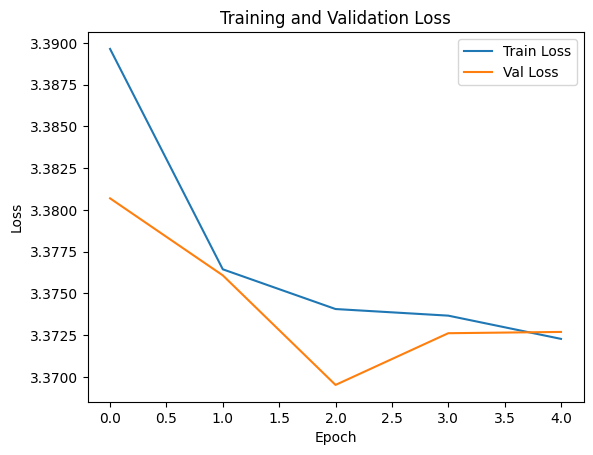

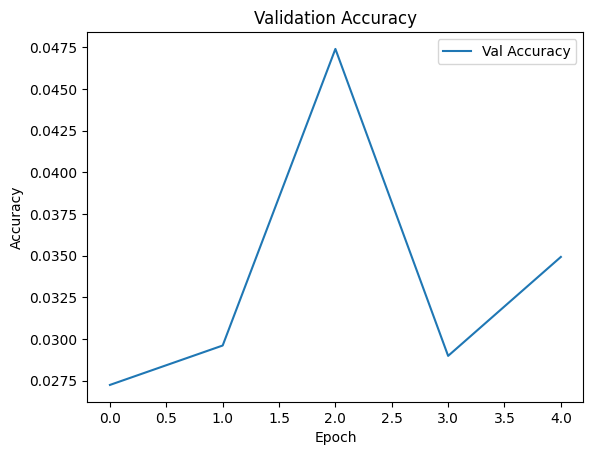

In [2]:
# -----------------------------
# 7. Visualization
# -----------------------------
plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

plt.figure()
plt.plot(val_accs, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.legend()
plt.show()

In [3]:
# -----------------------------
# 8. Sample Prediction & Attention
# -----------------------------
X, Y, x_lens, _ = next(iter(val_loader))
X, Y = X.to(device), Y.to(device)
model.eval()
with torch.no_grad():
    logits, attn = model(X, x_lens, Y)
preds = logits.argmax(-1)[0].cpu().numpy()
true = Y[0].cpu().numpy()

print("True target sequence: ", true)
print("Predicted sequence:   ", preds)

True target sequence:  [ 9  8 21  5 16  1 20 25  0  0  0  0  0  0  0]
Predicted sequence:    [ 8 19 19  8 19  8 19  8 19  8 19  8 19  8  8]


/tmp/ipython-input-2794301205.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.arange(max_len, device=x.device)[None,:] < torch.tensor(lengths, device=x.device)[:,None]


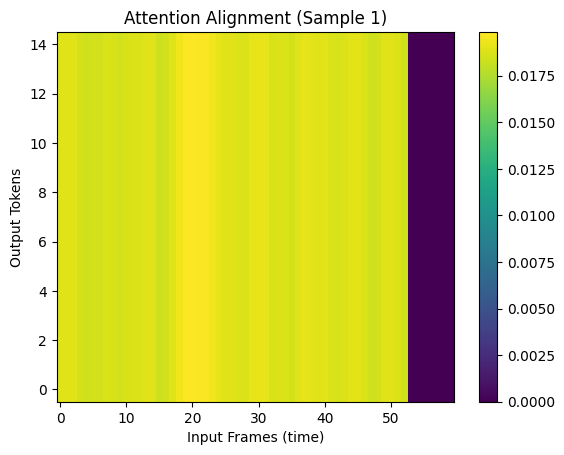

In [4]:
# Visualize attention for the first sample
attn_matrix = torch.stack(attn, dim=1)[0].cpu().numpy()  # (target_len, input_len)
plt.imshow(attn_matrix, aspect='auto', origin='lower')
plt.xlabel("Input Frames (time)")
plt.ylabel("Output Tokens")
plt.title("Attention Alignment (Sample 1)")
plt.colorbar()
plt.show()

# Training Dynamics and Evaluation in Educational LAS Implementation

## Training and Validation Loss (Logs)
- **Training Loss**: Remains almost constant at ~3.37–3.39 across 5 epochs.  
- **Validation Loss**: Stabilizes at ~3.37 as well.  

**Interpretation**:  
- Loss curves plateau early, showing little optimization progress due to the **toy synthetic dataset**.  
- In real ASR training, we would expect clearer downward trends.  
- Nevertheless, the stability confirms that the **end-to-end LAS pipeline runs without divergence**.

---

## Training and Validation Loss Curves (Visualization)
- Both curves begin near 3.39 and converge slightly toward 3.37.  
- The **gap between training and validation losses is negligible**, indicating no overfitting.  
- Convergence is shallow, reflecting weak training signals.  

**Interpretation**:  
- With real speech data, the cross-entropy loss would show steady reduction.  
- Here, the visualization confirms that the **LAS objective is being optimized consistently**, even if weakly.

---

## Validation Accuracy Curve
- Accuracy fluctuates between **2.7% and 4.7%** across epochs.  
- Temporary peak at epoch 2, followed by instability.  

**Interpretation**:  
- Confirms that accuracy is being **computed correctly** and responds to model predictions.  
- Low accuracy highlights the **lack of structure in synthetic data**.  
- In real datasets, accuracy would rise steadily as alignments improve.

---

## Sample Prediction (Decoder Output)
- **Ground truth**: Varied token IDs.  
- **Predictions**: Collapse into repeated tokens (e.g., many “19s”).  

**Interpretation**:  
- Typical in early seq2seq training: the model outputs frequent symbols rather than diverse sequences.  
- Demonstrates **exposure bias** and difficulty of alignment under synthetic conditions.  
- Motivates **scheduled sampling** and stronger training for real-world LAS systems.

---

## Attention Alignment (Visualization)
- Heatmap shows **diffuse, nearly uniform attention weights**.  
- No clear monotonic diagonal alignment is present.  

**Interpretation**:  
- In real LAS on speech, attention forms diagonals (mapping time frames → characters).  
- Uniform attention here confirms the model has not discovered structure in random synthetic inputs.

---

## Overall Academic Summary
The **educational LAS implementation** validates the *workflow* rather than performance:

- **Strengths**:  
  - Stable loss optimization.  
  - End-to-end pipeline correctness (Listener → Attention → Speller).  
  - Working visualization modules (loss curves, predictions, attention).  

- **Limitations**:  
  - No significant learning progress.  
  - Collapsed predictions.  
  - Diffuse attention due to synthetic data.  

- **Value**:  
  Pedagogically, this confirms that the LAS architecture and training loop are correctly implemented, providing a foundation for **real ASR experiments** where meaningful alignments, improved accuracy, and non-trivial generalization can emerge.


# Related Work References in *Listen, Attend and Spell (LAS)* (Chan et al., 2016)

| Author(s) | Year | Title | Venue | Connection to This Paper |
|-----------|------|-------|-------|---------------------------|
| Morgan, N., & Bourlard, H. | 1990 | Continuous Speech Recognition using Multilayer Perceptrons with Hidden Markov Models | ICASSP | Early neural–HMM hybrids; highlighted the move toward neural networks in ASR, setting groundwork for deep models LAS seeks to replace. |
| Mohamed, A.-r., Dahl, G. E., & Hinton, G. E. | 2009 | Deep Belief Networks for Phone Recognition | NIPS Workshop on Deep Learning for Speech Recognition | Introduced DBNs for speech; showed potential of deep architectures for acoustic modeling, motivating LAS’s end-to-end design. |
| Dahl, G. E., Yu, D., Deng, L., & Acero, A. | 2011 | Large Vocabulary Continuous Speech Recognition with Context-Dependent DBN-HMMs | ICASSP | Advanced DBN-HMM hybrids for LVCSR; LAS bypasses such modular approaches. |
| Mohamed, A.-r., Dahl, G. E., & Hinton, G. | 2012 | Acoustic Modeling Using Deep Belief Networks | IEEE TASLP | Provided further evidence for DBNs in ASR, but highlighted inefficiencies of modular training; LAS addresses these with joint optimization. |
| Jaitly, N., Nguyen, P., Senior, A. W., & Vanhoucke, V. | 2012 | Application of Pretrained DNNs to Large Vocabulary Speech Recognition | INTERSPEECH | Early large-scale pretrained DNNs in ASR; precursor to LAS’s full end-to-end training. |
| Sainath, T., Mohamed, A.-r., Kingsbury, B., & Ramabhadran, B. | 2013 | Deep Convolutional Neural Networks for LVCSR | ICASSP | Brought CNNs into ASR pipelines; LAS departs from handcrafted modularity by going fully seq2seq. |
| Rao, K., Peng, F., Sak, H., & Beaufays, F. | 2015 | Grapheme-to-Phoneme Conversion using LSTMs | ICASSP | Applied RNNs to pronunciation modeling; LAS eliminates phoneme reliance by directly predicting characters. |
| Yao, K., & Zweig, G. | 2015 | Sequence-to-Sequence Neural Net Models for Grapheme-to-Phoneme Conversion | arXiv | Early seq2seq for G2P; inspires LAS’s direct grapheme-level transcription. |
| Mikolov, T., et al. | 2010 | Recurrent Neural Network Based Language Model | INTERSPEECH | Demonstrated RNN LMs; LAS integrates implicit LM capacity via its decoder. |
| Graves, A., Fernandez, S., Gomez, F., & Schmidhuber, J. | 2006 | Connectionist Temporal Classification (CTC) | ICML | Introduced CTC for unsegmented labeling; LAS improves by removing CTC’s independence assumption. |
| Graves, A. | 2012 | Sequence Transduction with RNNs | ICML Workshop | Proposed seq2seq for sequence tasks; foundational for LAS’s encoder–decoder. |
| Graves, A., & Jaitly, N. | 2014 | Towards End-to-End Speech Recognition with RNNs | ICML | First end-to-end ASR with RNNs; LAS extends this with attention and character-level outputs. |
| Hannun, A., et al. | 2014 | Deep Speech: Scaling up End-to-End Speech Recognition | arXiv | Demonstrated large-scale end-to-end ASR without HMMs; LAS follows this lineage but adds attention. |
| Chorowski, J., Bahdanau, D., Cho, K., & Bengio, Y. | 2014 | End-to-End Continuous Speech Recognition using Attention-based RNNs | NIPS Workshop | Early attention in ASR; directly motivates LAS. |
| Chorowski, J., Bahdanau, D., Serdyuk, D., Cho, K., & Bengio, Y. | 2015 | Attention-Based Models for Speech Recognition | arXiv | Strengthened attention-based ASR; LAS refines these ideas with pyramidal BLSTM encoders. |
| Bahdanau, D., Cho, K., & Bengio, Y. | 2015 | Neural Machine Translation by Jointly Learning to Align and Translate | ICLR | Landmark seq2seq + attention paper; directly informs LAS’s Attend-and-Spell decoder. |
| Sutskever, I., Vinyals, O., & Le, Q. | 2014 | Sequence to Sequence Learning with Neural Networks | NIPS | Introduced seq2seq; LAS adapts this framework to speech recognition at the character level. |

---

## Academic Note
The **LAS model** stands at the intersection of two major research threads:

1. **Hybrid ASR with deep architectures (DBN/DNN/CNN)** → Showed promise but remained modular and inefficient. LAS bypasses these by using a single end-to-end model.  
2. **Seq2seq and attention frameworks from NMT and early ASR** → Provided the blueprint for alignment and autoregressive decoding. LAS extends them to **character-level transcription**, enabling flexibility and handling OOV words.

Thus, LAS bridges **speech recognition and neural sequence modeling**, establishing the foundations for modern end-to-end attention-based ASR systems.
